# Solving shortest path problem using ACO

In [1]:
from haversine import haversine
from collections import defaultdict
import pandas as pd
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

### Define the shorest path problem

In [2]:
# Define latitude and longitude for twenty major U.S. cities
cities = {
    'New York City': (40.72, -74.00),
    'Philadelphia': (39.95, -75.17),       
    'Baltimore': (39.28, -76.62),
    'Charlotte': (35.23, -80.85),
    'Memphis': (35.12, -89.97),
    'Jacksonville': (30.32, -81.70),
    'Houston': (29.77, -95.38),
    'Austin': (30.27, -97.77),
    'San Antonio': (29.53, -98.47),
    'Fort Worth': (32.75, -97.33),
    'Dallas': (32.78, -96.80),
    'San Diego': (32.78, -117.15),
    'Los Angeles': (34.05, -118.25),
    'San Jose': (37.30, -121.87),
    'San Francisco': (37.78, -122.42),    
    'Indianapolis': (39.78, -86.15),
    'Phoenix': (33.45, -112.07),       
    'Columbus': (39.98, -82.98), 
    'Chicago': (41.88, -87.63),
    'Detroit': (42.33, -83.05)
}

# Create a haversine distance matrix based on latitude-longitude coordinates
distance_matrix = defaultdict(dict)
for ka, va in cities.items():
    for kb, vb in cities.items():
        distance_matrix[ka][kb] = 0.0 if kb == ka else haversine((va[0], va[1]), (vb[0], vb[1])) 

# Convert distance dictionary into a dataframe        
distances = pd.DataFrame(distance_matrix)

# City names and indices mapping
city_names = list(distances.columns)
city_indices = {city: idx for idx, city in enumerate(city_names)}
city_count = len(city_names)

### Visualize the shorest path problem

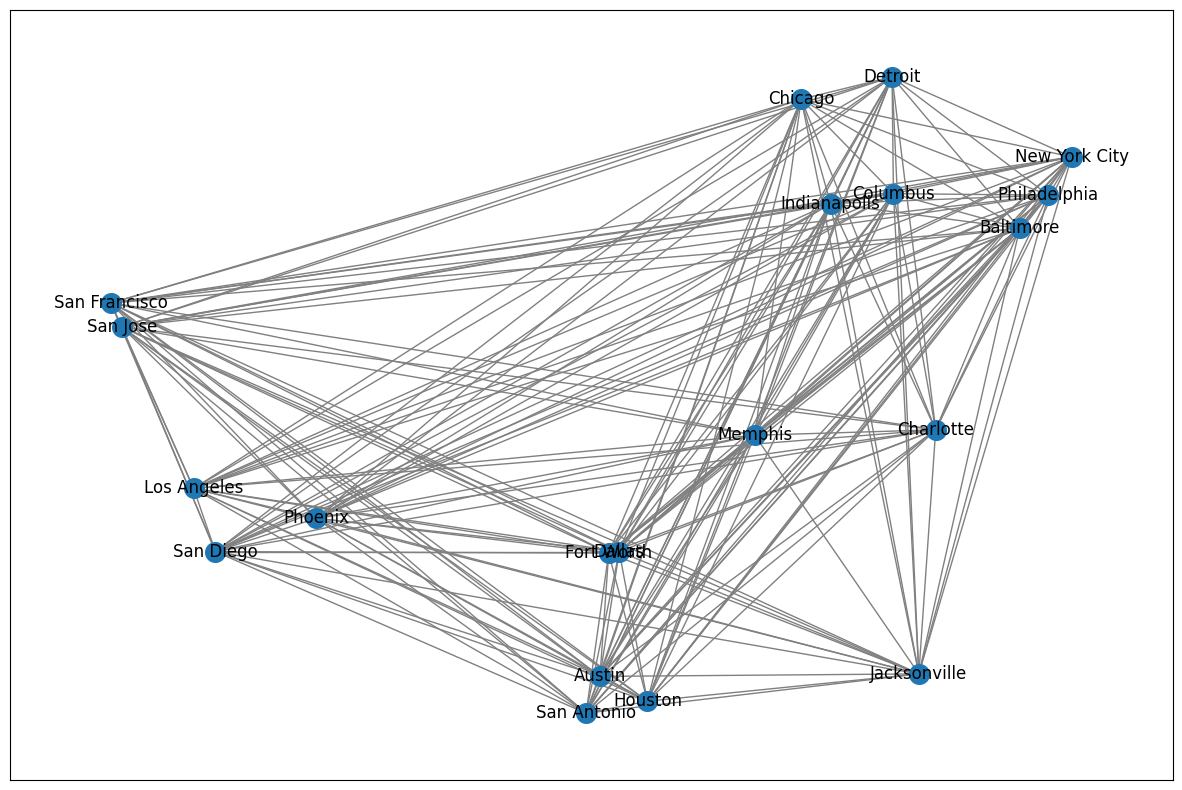

In [3]:
# Create a graph
G=nx.Graph()

for ka, va in cities.items():
    for kb, vb in cities.items():
        G.add_weighted_edges_from({(ka,kb, distance_matrix[ka][kb])})

G.remove_edges_from(nx.selfloop_edges(G))
        
fig, ax = plt.subplots(figsize=(15,10))

# Reverse lat and long for correct visualization
reversed_dict = {key: value[::-1] for key, value in cities.items()}

# Create an independent shallow copy of the graph and attributes
H = G.copy()
 
# Draw the network
ax=nx.draw_networkx(
    H,
    pos=reversed_dict,
    with_labels=True,
    edge_color="gray",
    node_size=200,
    width=1,
)

plt.show()

### Define cost function

In [4]:
def cost_function(path):
    distance = 0
    for i in range(len(path) - 1):
        city1, city2 = city_names[path[i]], city_names[path[i + 1]]
        distance += haversine(cities[city1], cities[city2])
    return distance

### Function to update pheromones

In [6]:
def update_pheromones(paths, pheromones):
    delta_pheromones = np.zeros_like(pheromones)

    for i in range(ants):
        for j in range(city_count - 1):
            city1_idx, city2_idx = paths[i, j], paths[i, j + 1]
            delta_pheromones[city1_idx, city2_idx] += Q / cost_function(paths[i])

    # Add pheromones for returning to the starting city
    for i in range(ants):
        city1_idx, city2_idx = paths[i, -1], paths[i, 0]
        delta_pheromones[city1_idx, city2_idx] += Q / cost_function(paths[i])

    return (1 - evaporation_rate) * pheromones + delta_pheromones

### Function to generate ant paths

In [ ]:
def ant_tour(pheromones, distances): 
    paths = np.empty((ants, city_count), dtype=int)
    for ant in range(ants):
        path = [city_indices['New York City']]  # Start from New York
        unvisited_cities = set(range(city_count))
        unvisited_cities.remove(path[0])

        while unvisited_cities:
            current_city = path[-1]
            probabilities = []

            for city in unvisited_cities:
                tau = pheromones[current_city, city] 
                eta = (1 / distances[current_city, city])
                probabilities.append((tau**alpha)*(eta**beta))

            probabilities /= sum(probabilities)
            next_city = np.random.choice(list(unvisited_cities), p=probabilities)
            unvisited_cities.remove(next_city)
            path.append(next_city)

        paths[ant] = path
    
    return paths

### Function to run ACO

In [7]:
def run_ACO(distances, ants, iterations, alpha, beta, evaporation_rate, Q):
    pheromones = np.ones((city_count, city_count))
    best_path = None
    best_distance = float('inf')

    for _ in tqdm(range(iterations), desc="Running ACO", unit="iteration"):
        # Generate paths for each ant
        paths = ant_tour(pheromones, distances)

        distances_paths = np.array([cost_function(path) for path in paths])
        min_idx = distances_paths.argmin()
        min_distance = distances_paths[min_idx]

        if min_distance < best_distance:
            best_distance = min_distance
            best_path = paths[min_idx]

        # Update pheromones
        pheromones = update_pheromones(paths, pheromones)

    return best_path, best_distance

### Run ACO with the predefined parameters

In [9]:
# ACO parameters
ants = 30
iterations = 100
alpha = 1
beta = 0.9
evaporation_rate = 0.5
Q = 100

# Run ACO with the predefined parameters
best_path, best_distance = run_ACO(distances.values, ants, iterations, alpha, beta, evaporation_rate, Q)

Running ACO: 100%|██████████| 100/100 [00:19<00:00,  5.24iteration/s]


### Print the results

In [10]:
city_names_tour=[city_names[i] for i in best_path]
Route = " → ".join(city_names_tour)
print("Route:", Route)
print("Route length:", np.round(best_distance, 3))

Route: New York City → Philadelphia → Baltimore → Detroit → Chicago → Indianapolis → Columbus → Charlotte → Jacksonville → Memphis → Fort Worth → Dallas → Houston → Austin → San Antonio → Phoenix → San Diego → Los Angeles → San Jose → San Francisco
Route length: 7937.115


### Visualize the obtained route

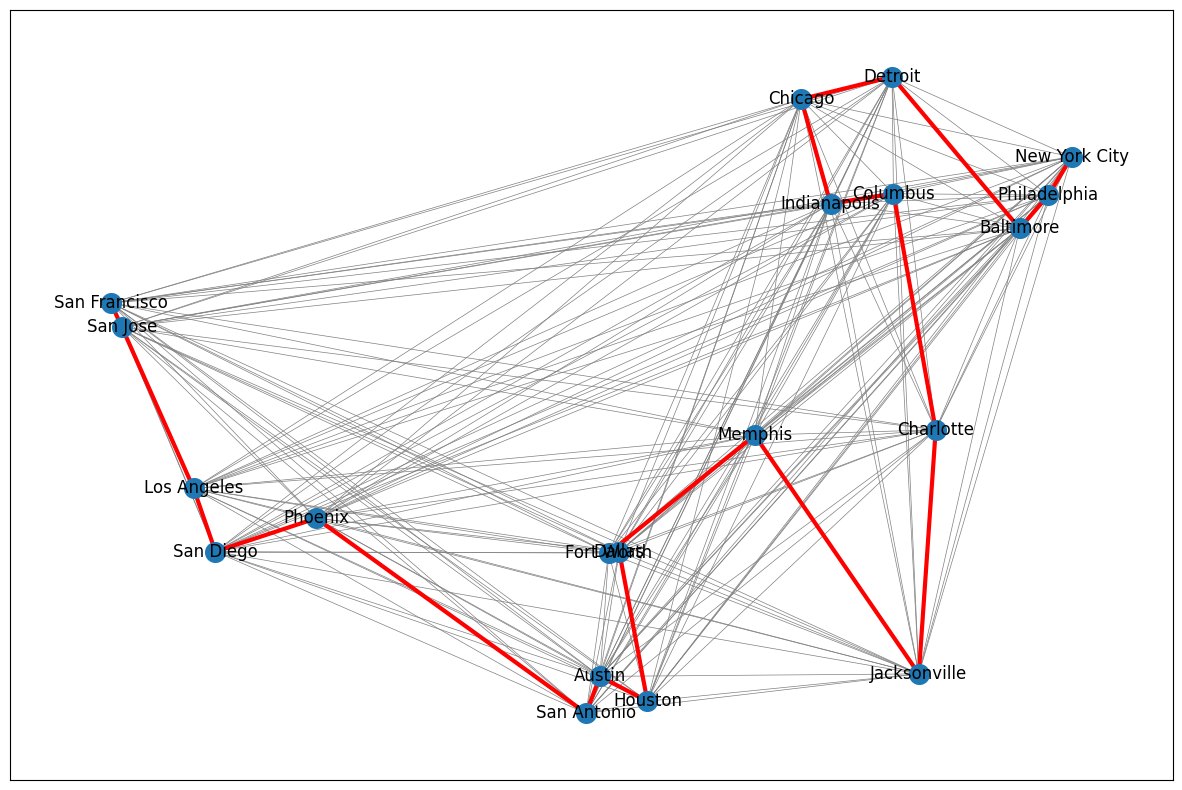

In [11]:
fig, ax = plt.subplots(figsize=(15,10))

# Create an independent shallow copy of the graph and attributes
H = G.copy()

# Reverse lat and long for correct visualization
reversed_dict = {key: value[::-1] for key, value in cities.items()}

# Create edge list
edge_list =list(nx.utils.pairwise(city_names_tour))

# Draw closest edges on each node only
nx.draw_networkx_edges(H, pos=reversed_dict, edge_color="gray", width=0.5)

# Draw the route
ax=nx.draw_networkx(
    H,
    pos=reversed_dict,
    with_labels=True,
    edgelist=edge_list,
    edge_color="red",
    node_size=200,
    width=3,
)

# plt.show()
plt.savefig('CH10_12_TSP_ACO.png', format='png', bbox_inches='tight', dpi=300)

# Solving TSP using ACOpy

In [12]:
# !pip install acopy

In [13]:
import acopy
import networkx as nx

G=nx.Graph()

for ka, va in cities.items():
    for kb, vb in cities.items():
        G.add_weighted_edges_from({(ka,kb, distance_matrix[ka][kb])})
G.remove_edges_from(nx.selfloop_edges(G))

# ACO parameters
evaporation_rate = 0.5
iterations = 100
Q = 100

# Set up the ACO solver
solver = acopy.Solver(rho=evaporation_rate, q=Q)

# Set up the ACO colony with alpha and beta parameters
colony = acopy.Colony(alpha=1, beta=0.9)

# Run the ACO algorithm
for n_iter in range(iterations):
    tour = solver.solve(G, colony, limit=4)
    path_indices = ['New York City']  # Start with City 0 (New York City) 
    for edge in tour.path:
        # Add the other node from the edge that is not already in the path
        next_city = edge[0] if edge[1] == path_indices[-1] else edge[1]
        if next_city not in path_indices:
            path_indices.append(next_city)
    # # path_indices.append(0)  # Close the loop by adding City 0 again in case of TSP
    # if len(set(path_indices)) == len(cities) + 1:
    #     break

tour.path=path_indices

### Print the results

In [14]:
# Print the best solution
best_path = tour.path
best_distance = tour.cost
Route = " → ".join(best_path)
print("Route:", Route)
print("Route length:", np.round(best_distance, 3))

Route: New York City → Baltimore → Philadelphia → Charlotte → Jacksonville → Memphis → Fort Worth → Dallas → Houston → Austin → San Antonio → Phoenix → San Diego → Los Angeles → San Jose → San Francisco → Chicago → Detroit → Indianapolis → Columbus
Route length: 11248.752


### Visualize the obtained route

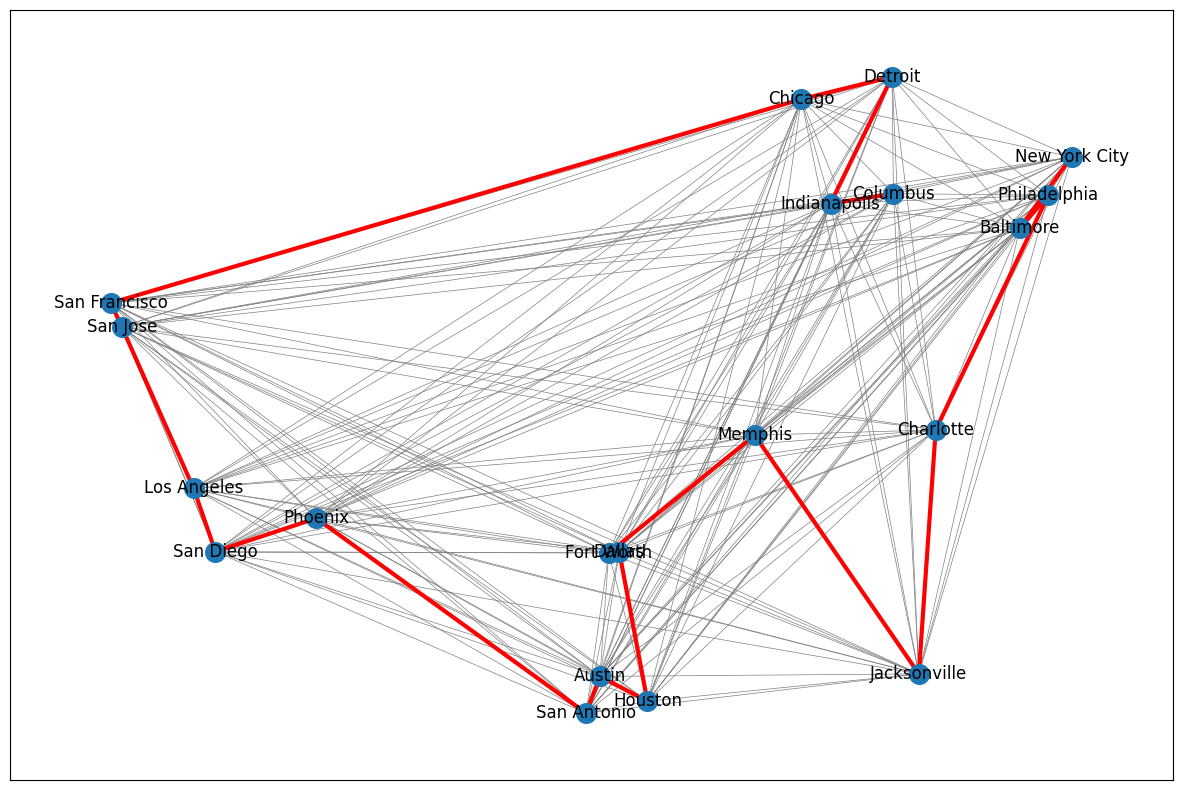

In [15]:
fig, ax = plt.subplots(figsize=(15,10))

# Create an independent shallow copy of the graph and attributes
H = G.copy()

# Reverse lat and long for correct visualization
reversed_dict = {key: value[::-1] for key, value in cities.items()}

# Create edge list
edge_list =list(nx.utils.pairwise(best_path))

# Draw closest edges on each node only
nx.draw_networkx_edges(H, pos=reversed_dict, edge_color="gray", width=0.5)

# Draw the route
ax=nx.draw_networkx(
    H,
    pos=reversed_dict,
    with_labels=True,
    edgelist=edge_list,
    edge_color="red",
    node_size=200,
    width=3,
)

# plt.show()
plt.savefig('CH10_13_ACOpy.png', format='png', bbox_inches='tight', dpi=300)